# Apple (AAPL) Stock Price Prediction — LSTM, BiLSTM & GRU 📈

**Description:** This notebook walks through time-series forecasting of Apple's (AAPL) *Close* price using three deep recurrent models: LSTM, Bidirectional LSTM (BiLSTM), and GRU. The notebook is designed to be runnable end-to-end and explained in simple English so that even a high-school student can follow.

**What you'll get:**
- Data download (from Yahoo Finance using `yfinance`) from **2015-01-01** to **2025-10-15**.
- Exploratory analysis (plots, summary statistics).
- Preprocessing: scaling and sequence windowing.
- Train/validation/test splitting (time-series-aware).
- Model definitions: LSTM, BiLSTM, GRU.
- Training loops, evaluation (MAE, RMSE, MAPE), and plots comparing predictions.
- Short discussion of results and suggestions for next steps.

---

**How to use:** Run the notebook cells in order. If you run this on a machine without internet, the cell that downloads data will fail — then you can replace the data-loading cell with a local CSV of AAPL historical prices.

---


In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

print('Libraries imported successfully')


Libraries imported successfully


## 1) Download historical data

We'll download daily historical data for Apple (ticker `AAPL`) from Yahoo Finance using `yfinance`. Dates: **2015-01-01** to **2025-10-15** (end date chosen as an example — adjust as needed).


In [18]:
# Download data
start = '2015-01-01'
end = '2025-10-15'  # change if you want a different end date

df = yf.download('AAPL', start=start, end=end)

df.head()


/tmp/ipython-input-1526924348.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261049,24.729272,23.821673,24.718176,212818400
2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000
2015-01-06,23.579794,23.839424,23.218085,23.641928,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829123,24.886819,24.121240,24.238852,237458000


In [24]:
import os
SEQ_LEN = 60         # how many past days we feed to predict next day
FUTURE_DAYS = 30     # forecast horizon for final demo
TEST_RATIO = 0.15
VAL_RATIO = 0.10
BATCH = 32
EPOCHS = 30
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)


## 2) Quick Exploratory Data Analysis (EDA)

We'll inspect the shape, missing values, and visualize the closing price over time.


Shape: (2712, 5)

Missing values:
 Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


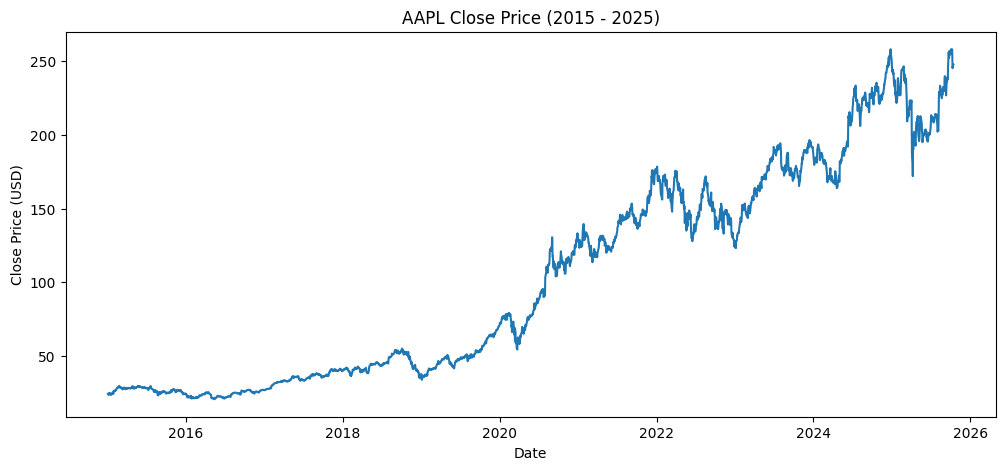

In [19]:
# Basic info
print('Shape:', df.shape)
print('\nMissing values:\n', df.isna().sum())

# Plot Close price
plt.figure(figsize=(12,5))
plt.plot(aapl.index, aapl['Close'])
plt.title('AAPL Close Price (2015 - 2025)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.show()


## Step 2 — Preprocessing
**Decisions and why:**  
- Keep features: `Open, High, Low, Close, Volume` (multivariate).  
- Fill missing values (if any) with forward-fill — keeps chronological consistency.  
- Scale features using `MinMaxScaler` (0–1) — LSTMs perform better with scaled inputs.

In [20]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].copy()
data = data.ffill().dropna()   # forward fill then drop remaining NaNs if any
print("After ffill shape:", data.shape)

After ffill shape: (2712, 5)


In [25]:
import joblib
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)   # shape (n_days, 5)
# Save scaler to reuse in deployment
joblib.dump(scaler, os.path.join(MODEL_DIR, "multiple_input_scaler.gz"))
print("Scaler saved.")

Scaler saved.


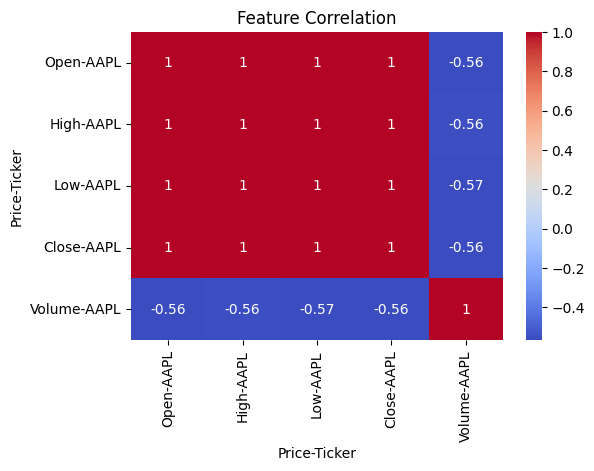

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()  # shape (n_samples, 1)

In [28]:
# Cell 8 — create sequences (multivariate)
def create_multivariate_sequences(scaled_array, seq_len):
    X, y = [], []
    for i in range(seq_len, len(scaled_array)):
        X.append(scaled_array[i-seq_len:i, :])   # seq_len x n_features
        # target: next-day close (column index for 'Close' is 3 in our features)
        y.append(scaled_array[i, features.index('Close')])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_all, y_all = create_multivariate_sequences(scaled_data, SEQ_LEN)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)


X_all shape: (2652, 60, 5) y_all shape: (2652,)


### 3.1) Time-based train/validation/test split

We'll keep the time order: first 80% train, next 10% validation, final 10% test.


In [37]:
# Cell 9 — time-aware split
n = len(X_all)
test_size = int(n * TEST_RATIO)
val_size = int(n * VAL_RATIO)

train_end = n - test_size - val_size
val_end = n - test_size

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (1990, 60, 5) (1990,)
Val:   (265, 60, 5) (265,)
Test:  (397, 60, 5) (397,)


## 4) Models: LSTM, BiLSTM, GRU

We'll define helper functions to build each model type and train them with early stopping. We'll keep architectures simple so they train reasonably fast.


In [38]:
# Cell 10 — Helper build functions (simple & clear models)
def build_lstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_bilstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape),
        Dropout(dropout),
        Bidirectional(LSTM(units//2)),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_gru(input_shape, units=64, dropout=0.2):
    m = Sequential([
        GRU(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        GRU(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m


In [41]:
# Cell 11 — training helper
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
def compile_and_train(model, name, X_train, y_train, X_val, y_val, epochs=EPOCHS):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint(os.path.join(MODEL_DIR, f"{name}.h5"), monitor='val_loss', save_best_only=True, verbose=1)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=BATCH, callbacks=callbacks, verbose=2)
    return history


In [42]:
# Cell 12 — Build & train LSTM (simple)
input_shape = (X_train.shape[1], X_train.shape[2])
lstm = build_lstm(input_shape, units=128, dropout=0.2)
lstm_hist = compile_and_train(lstm, "lstm_multifeature", X_train, y_train, X_val, y_val)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00132, saving model to saved_models/lstm_multifeature.h5


63/63 - 6s - 96ms/step - loss: 0.0145 - mae: 0.0702 - val_loss: 0.0013 - val_mae: 0.0313 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.00132 to 0.00057, saving model to saved_models/lstm_multifeature.h5


63/63 - 4s - 71ms/step - loss: 0.0020 - mae: 0.0287 - val_loss: 5.6985e-04 - val_mae: 0.0201 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss did not improve from 0.00057
63/63 - 4s - 62ms/step - loss: 0.0014 - mae: 0.0246 - val_loss: 0.0013 - val_mae: 0.0311 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss did not improve from 0.00057
63/63 - 5s - 80ms/step - loss: 0.0014 - mae: 0.0244 - val_loss: 5.8453e-04 - val_mae: 0.0192 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 5: val_loss improved from 0.00057 to 0.00057, saving model to saved_models/lstm_multifeature.h5


63/63 - 4s - 71ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 5.6938e-04 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss improved from 0.00057 to 0.00056, saving model to saved_models/lstm_multifeature.h5


63/63 - 5s - 74ms/step - loss: 0.0012 - mae: 0.0220 - val_loss: 5.5763e-04 - val_mae: 0.0188 - learning_rate: 5.0000e-05
Epoch 7/30

Epoch 7: val_loss did not improve from 0.00056
63/63 - 6s - 88ms/step - loss: 0.0012 - mae: 0.0223 - val_loss: 8.9073e-04 - val_mae: 0.0254 - learning_rate: 5.0000e-05
Epoch 8/30

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_loss did not improve from 0.00056
63/63 - 4s - 64ms/step - loss: 9.7711e-04 - mae: 0.0204 - val_loss: 0.0010 - val_mae: 0.0273 - learning_rate: 5.0000e-05
Epoch 9/30

Epoch 9: val_loss did not improve from 0.00056
63/63 - 4s - 61ms/step - loss: 0.0010 - mae: 0.0209 - val_loss: 6.6160e-04 - val_mae: 0.0219 - learning_rate: 2.5000e-05
Epoch 10/30

Epoch 10: val_loss did not improve from 0.00056
63/63 - 5s - 73ms/step - loss: 0.0012 - mae: 0.0220 - val_loss: 6.3729e-04 - val_mae: 0.0215 - learning_rate: 2.5000e-05
Epoch 11/30

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.24999996842

In [43]:
# Cell 13 — Build & train BiLSTM
bilstm = build_bilstm(input_shape, units=128, dropout=0.2)
bilstm_hist = compile_and_train(bilstm, "bilstm_multifeature", X_train, y_train, X_val, y_val)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00199, saving model to saved_models/bilstm_multifeature.h5


63/63 - 14s - 226ms/step - loss: 0.0085 - mae: 0.0557 - val_loss: 0.0020 - val_mae: 0.0397 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss did not improve from 0.00199
63/63 - 10s - 152ms/step - loss: 0.0019 - mae: 0.0281 - val_loss: 0.0023 - val_mae: 0.0410 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.00199 to 0.00181, saving model to saved_models/bilstm_multifeature.h5


63/63 - 10s - 158ms/step - loss: 0.0017 - mae: 0.0261 - val_loss: 0.0018 - val_mae: 0.0367 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss did not improve from 0.00181
63/63 - 9s - 148ms/step - loss: 0.0013 - mae: 0.0231 - val_loss: 0.0021 - val_mae: 0.0387 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 0.00181 to 0.00158, saving model to saved_models/bilstm_multifeature.h5


63/63 - 11s - 173ms/step - loss: 0.0011 - mae: 0.0218 - val_loss: 0.0016 - val_mae: 0.0337 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss did not improve from 0.00158
63/63 - 9s - 146ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 0.0020 - val_mae: 0.0384 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss improved from 0.00158 to 0.00086, saving model to saved_models/bilstm_multifeature.h5


63/63 - 9s - 138ms/step - loss: 9.3262e-04 - mae: 0.0201 - val_loss: 8.5949e-04 - val_mae: 0.0254 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: val_loss did not improve from 0.00086
63/63 - 10s - 163ms/step - loss: 7.5406e-04 - mae: 0.0182 - val_loss: 0.0033 - val_mae: 0.0530 - learning_rate: 1.0000e-04
Epoch 9/30

Epoch 9: val_loss did not improve from 0.00086
63/63 - 9s - 147ms/step - loss: 8.1147e-04 - mae: 0.0185 - val_loss: 0.0019 - val_mae: 0.0388 - learning_rate: 1.0000e-04
Epoch 10/30

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: val_loss did not improve from 0.00086
63/63 - 9s - 147ms/step - loss: 7.3254e-04 - mae: 0.0176 - val_loss: 0.0021 - val_mae: 0.0417 - learning_rate: 1.0000e-04
Epoch 11/30

Epoch 11: val_loss did not improve from 0.00086
63/63 - 11s - 176ms/step - loss: 7.4340e-04 - mae: 0.0179 - val_loss: 0.0019 - val_mae: 0.0394 - learning_rate: 5.0000e-05
Epoch 12/30

Epoch 12: val_loss improved from 0.00086 to 0.00080, 

63/63 - 9s - 149ms/step - loss: 6.5343e-04 - mae: 0.0168 - val_loss: 8.0168e-04 - val_mae: 0.0242 - learning_rate: 5.0000e-05
Epoch 13/30

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 13: val_loss did not improve from 0.00080
63/63 - 10s - 162ms/step - loss: 6.6212e-04 - mae: 0.0169 - val_loss: 8.3614e-04 - val_mae: 0.0248 - learning_rate: 5.0000e-05
Epoch 14/30

Epoch 14: val_loss did not improve from 0.00080
63/63 - 10s - 160ms/step - loss: 6.7116e-04 - mae: 0.0167 - val_loss: 0.0012 - val_mae: 0.0301 - learning_rate: 2.5000e-05
Epoch 15/30

Epoch 15: val_loss did not improve from 0.00080
63/63 - 10s - 154ms/step - loss: 6.5988e-04 - mae: 0.0169 - val_loss: 9.5487e-04 - val_mae: 0.0266 - learning_rate: 2.5000e-05
Epoch 16/30

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 16: val_loss did not improve from 0.00080
63/63 - 10s - 162ms/step - loss: 6.0326e-04 - mae: 0.0163 - val_loss: 0.0012 - val_mae: 0.0295 - 

63/63 - 9s - 149ms/step - loss: 6.3308e-04 - mae: 0.0165 - val_loss: 6.6725e-04 - val_mae: 0.0221 - learning_rate: 1.2500e-05
Epoch 18/30

Epoch 18: val_loss did not improve from 0.00067
63/63 - 10s - 161ms/step - loss: 6.1346e-04 - mae: 0.0162 - val_loss: 9.8386e-04 - val_mae: 0.0270 - learning_rate: 1.2500e-05
Epoch 19/30

Epoch 19: val_loss did not improve from 0.00067
63/63 - 10s - 162ms/step - loss: 6.2900e-04 - mae: 0.0164 - val_loss: 9.6226e-04 - val_mae: 0.0267 - learning_rate: 1.2500e-05
Epoch 20/30

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 20: val_loss did not improve from 0.00067
63/63 - 11s - 167ms/step - loss: 6.8157e-04 - mae: 0.0168 - val_loss: 8.9262e-04 - val_mae: 0.0257 - learning_rate: 1.2500e-05
Epoch 21/30

Epoch 21: val_loss did not improve from 0.00067
63/63 - 9s - 149ms/step - loss: 6.4226e-04 - mae: 0.0164 - val_loss: 7.2254e-04 - val_mae: 0.0230 - learning_rate: 6.2500e-06
Epoch 22/30

Epoch 22: val_loss improved from 

63/63 - 9s - 140ms/step - loss: 6.2949e-04 - mae: 0.0164 - val_loss: 6.5573e-04 - val_mae: 0.0219 - learning_rate: 6.2500e-06
Epoch 23/30

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 23: val_loss did not improve from 0.00066
63/63 - 10s - 152ms/step - loss: 6.1302e-04 - mae: 0.0159 - val_loss: 0.0010 - val_mae: 0.0275 - learning_rate: 6.2500e-06
Epoch 24/30

Epoch 24: val_loss improved from 0.00066 to 0.00065, saving model to saved_models/bilstm_multifeature.h5


63/63 - 9s - 148ms/step - loss: 6.0144e-04 - mae: 0.0160 - val_loss: 6.5016e-04 - val_mae: 0.0217 - learning_rate: 3.1250e-06
Epoch 25/30

Epoch 25: val_loss did not improve from 0.00065
63/63 - 10s - 162ms/step - loss: 5.8201e-04 - mae: 0.0158 - val_loss: 8.9744e-04 - val_mae: 0.0258 - learning_rate: 3.1250e-06
Epoch 26/30

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 26: val_loss did not improve from 0.00065
63/63 - 9s - 148ms/step - loss: 6.3265e-04 - mae: 0.0164 - val_loss: 7.7177e-04 - val_mae: 0.0238 - learning_rate: 3.1250e-06
Epoch 27/30

Epoch 27: val_loss did not improve from 0.00065
63/63 - 10s - 157ms/step - loss: 6.1955e-04 - mae: 0.0163 - val_loss: 7.9602e-04 - val_mae: 0.0242 - learning_rate: 1.5625e-06
Epoch 28/30

Epoch 28: val_loss did not improve from 0.00065
63/63 - 9s - 140ms/step - loss: 6.0475e-04 - mae: 0.0161 - val_loss: 7.5627e-04 - val_mae: 0.0235 - learning_rate: 1.5625e-06
Epoch 29/30

Epoch 29: ReduceLROnPlateau reduci

In [44]:
# Cell 14 — Build & train GRU
gru = build_gru(input_shape, units=128, dropout=0.2)
gru_hist = compile_and_train(gru, "gru_multifeature", X_train, y_train, X_val, y_val)


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00031, saving model to saved_models/gru_multifeature.h5


63/63 - 6s - 102ms/step - loss: 0.0099 - mae: 0.0621 - val_loss: 3.0783e-04 - val_mae: 0.0143 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss did not improve from 0.00031
63/63 - 4s - 56ms/step - loss: 0.0022 - mae: 0.0307 - val_loss: 6.1026e-04 - val_mae: 0.0212 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.00031 to 0.00028, saving model to saved_models/gru_multifeature.h5


63/63 - 4s - 65ms/step - loss: 0.0018 - mae: 0.0276 - val_loss: 2.8182e-04 - val_mae: 0.0135 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_loss did not improve from 0.00028
63/63 - 4s - 57ms/step - loss: 0.0015 - mae: 0.0255 - val_loss: 5.9437e-04 - val_mae: 0.0209 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss did not improve from 0.00028
63/63 - 6s - 89ms/step - loss: 0.0014 - mae: 0.0240 - val_loss: 2.8790e-04 - val_mae: 0.0137 - learning_rate: 5.0000e-05
Epoch 6/30

Epoch 6: val_loss did not improve from 0.00028
63/63 - 5s - 72ms/step - loss: 0.0014 - mae: 0.0243 - val_loss: 3.0344e-04 - val_mae: 0.0142 - learning_rate: 5.0000e-05
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 7: val_loss did not improve from 0.00028
63/63 - 4s - 56ms/step - loss: 0.0013 - mae: 0.0235 - val_loss: 5.0537e-04 - val_mae: 0.0190 - learning_rate: 5.0000e-05
Epoch

## 5) Evaluation

For each model: predict on test set, inverse-transform values back to original price scale, and compute MAE, RMSE, MAPE. Then plot actual vs predicted.


In [46]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Cell 16 — evaluation helper (inverse transform predictions)
def invert_and_metrics(model, X, y_scaled, scaler, feature_index=features.index('Close')):
    preds_scaled = model.predict(X)
    # preds_scaled shape (n,1)
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))  # create placeholder
    preds_full[:, feature_index] = preds_scaled[:,0]
    preds_inv = scaler.inverse_transform(preds_full)[:, feature_index]

    y_full = np.zeros((len(y_scaled), scaled_data.shape[1]))
    y_full[:, feature_index] = y_scaled
    y_inv = scaler.inverse_transform(y_full)[:, feature_index]

    rmse = math.sqrt(mean_squared_error(y_inv, preds_inv))
    mae = mean_absolute_error(y_inv, preds_inv)
    r2 = r2_score(y_inv, preds_inv)
    return preds_inv, y_inv, rmse, mae, r2

# Evaluate LSTM
lstm_pred, y_test_inv, lstm_rmse, lstm_mae, lstm_r2 = invert_and_metrics(lstm, X_test, y_test, scaler)
print("LSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(lstm_rmse, lstm_mae, lstm_r2))

# Evaluate BiLSTM
bilstm_pred, _, bilstm_rmse, bilstm_mae, bilstm_r2 = invert_and_metrics(bilstm, X_test, y_test, scaler)
print("BiLSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(bilstm_rmse, bilstm_mae, bilstm_r2))

# Evaluate GRU
gru_pred, _, gru_rmse, gru_mae, gru_r2 = invert_and_metrics(gru, X_test, y_test, scaler)
print("GRU -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(gru_rmse, gru_mae, gru_r2))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM -> RMSE: 9.293, MAE: 7.288, R2: 0.829
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
BiLSTM -> RMSE: 14.181, MAE: 12.130, R2: 0.603
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
GRU -> RMSE: 7.773, MAE: 6.049, R2: 0.881


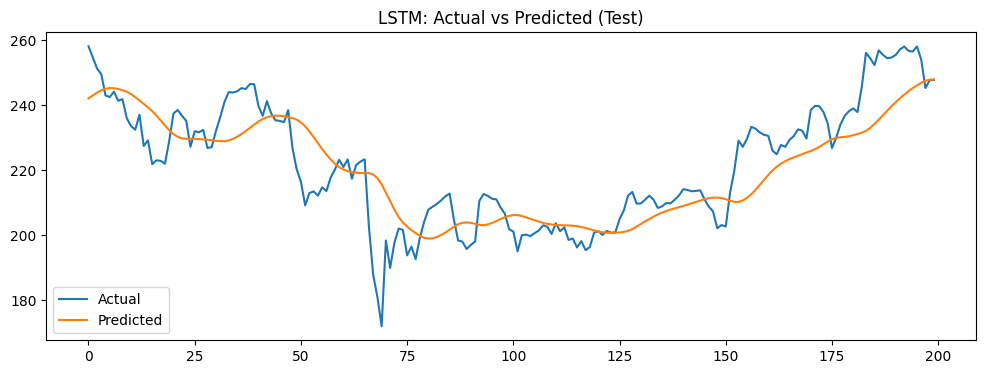

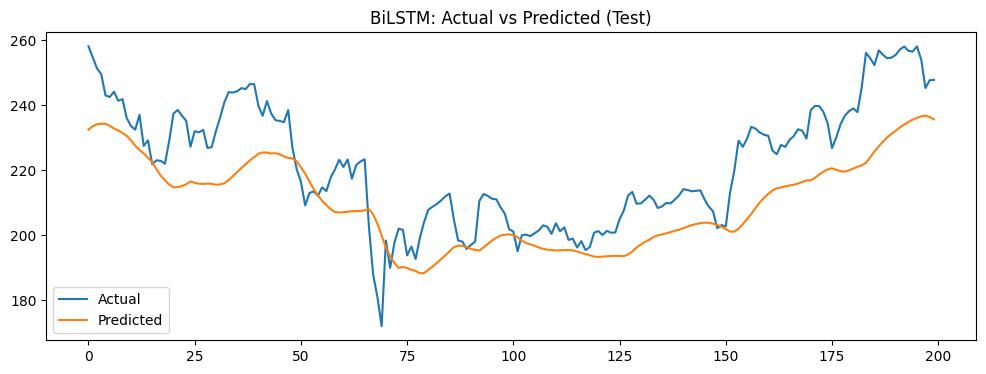

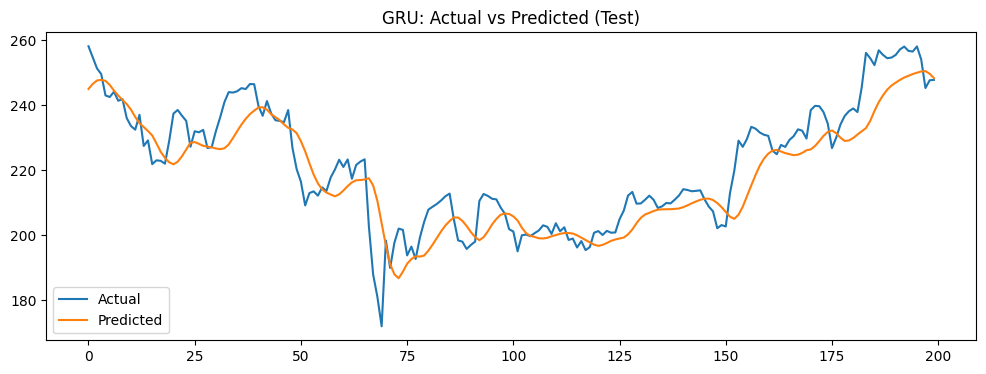

In [47]:
# Cell 17 — plot helper (last N points)
def plot_compare(y_true, preds, title, last_n=200):
    plt.figure(figsize=(12,4))
    plt.plot(y_true[-last_n:], label='Actual')
    plt.plot(preds[-last_n:], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare(y_test_inv, lstm_pred, "LSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, bilstm_pred, "BiLSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, gru_pred, "GRU: Actual vs Predicted (Test)", last_n=200)


In [48]:
# Cell 18 — pick best by RMSE
rmse_dict = {'lstm': lstm_rmse, 'bilstm': bilstm_rmse, 'gru': gru_rmse}
best_name = min(rmse_dict, key=rmse_dict.get)
print("Best model by RMSE:", best_name, rmse_dict)
best_model = {'lstm': lstm, 'bilstm': bilstm, 'gru': gru}[best_name]


Best model by RMSE: gru {'lstm': 9.29322422556414, 'bilstm': 14.180701343387648, 'gru': 7.773236407958408}


In [49]:
# Cell 20 — save best model name explicitly
best_model.save(os.path.join(MODEL_DIR, f"best_model_{best_name}.h5"))
print("Saved best model:", os.path.join(MODEL_DIR, f"best_model_{best_name}.h5"))


Saved best model: saved_models/best_model_gru.h5


In [51]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-10-08,258.059998,258.519989,256.109985,256.519989,36496900
2025-10-09,254.039993,258.000000,253.139999,257.809998,38322000
2025-10-10,245.270004,256.380005,244.000000,254.940002,61999100
2025-10-13,247.660004,249.690002,245.559998,249.380005,38142900
2025-10-14,247.770004,248.845001,244.699997,246.615005,35410253
